In [ ]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
using LinearAlgebra
using StaticArrays

################################################################################
# Constants
################################################################################
const R_EARTH = 6378.137  # Spherical Earth radius (km)

################################################################################
# Basic geometry helpers
################################################################################
""" Rotation matrix about the x-axis by angle θ. """
function rotX(θ)
    c = cos(θ)
    s = sin(θ)
    @SMatrix [
        1.0   0.0   0.0
        0.0    c    -s
        0.0    s     c
    ]
end

""" Rotation matrix about the y-axis by angle θ. """
function rotY(θ)
    c = cos(θ)
    s = sin(θ)
    @SMatrix [
         c   0.0    s
        0.0  1.0   0.0
        -s   0.0    c
    ]
end

"""Convert (lat, lon) in radians + radius to ECEF coordinates (x, y, z)."""
function latlon_to_ecef(lat::Float64, lon::Float64, r::Float64)
    x = r * cos(lat) * cos(lon)
    y = r * cos(lat) * sin(lon)
    z = r * sin(lat)
    return @SVector [x, y, z]
end

"""Convert ECEF (x, y, z) to spherical lat/lon in radians."""
function ecef_to_latlon(pos::SVector{3,Float64})
    x, y, z = pos
    r_xy = sqrt(x^2 + y^2)
    lat  = atan(z, r_xy)
    lon  = atan(y, x)
    return (lat, lon)
end


################################################################################
# Build local East, North, Up (ENU) axes at the sub-satellite point (lat0, lon0).
#   lat0, lon0 in radians
#   Returns (e, n, u) as normalized 3D vectors in ECEF frame.
################################################################################
function build_enu(lat0::Float64, lon0::Float64)
    # Up vector (local zenith)
    u = SVector{3}( cos(lat0)*cos(lon0),
                    cos(lat0)*sin(lon0),
                    sin(lat0) )

    # East vector
    e = SVector{3}(-sin(lon0), cos(lon0), 0.0)

    # North vector
    n = cross(u, e)  # or cross(e, u), depending on sign convention
    return (e, n, u)
end

################################################################################
# Main function: given:
#   lat0, lon0: sub-satellite lat/lon in radians
#   h: satellite altitude above Earth (km)
#   pitch, roll: angles in radians
#
# Returns:
#   dLat, dLon - the difference (in degrees) from (lat0, lon0) to the target
#                intersection point on Earth’s surface
################################################################################
function relative_latlon_offset(
        lat0::Float64,
        lon0::Float64,
        h::Float64,
        pitch::Float64,
        roll::Float64;
        R::Float64 = R_EARTH
    )

    # 1) Satellite position in ECEF:
    r_satellite = R + h
    sat_ecef = latlon_to_ecef(lat0, lon0, r_satellite)

    # 2) Local ENU axes at sub-satellite point:
    ê, n̂, û = build_enu(lat0, lon0)

    # 3) Define the nadir direction in local coordinates.
    #    In our local ENU, the “down” (nadir) direction is -û.
    #    We'll store it as a 3×1 vector: v_local = [0, 0, -1] is simpler
    #    but we need to align with the actual ENU basis if applying rotation
    #    in that local coordinate frame.
    # 
    #    We'll do this:
    #      - start with the local-vector [0,0,-1],
    #      - apply roll about x, then pitch about y,
    #      - then map it into ECEF.
    #
    #    So the local tangent coordinate system is X = ê, Y = n̂, Z = û.
    #    v_local = (0, 0, -1).
    #
    v_local_nadir = SVector{3}(0.0, 0.0, -1.0)

    # 4) Build the total rotation in local coordinates:
    #    roll about x => Rx(roll)
    #    pitch about y => Ry(pitch)
    #    final local vector = Ry(pitch)*Rx(roll)*v_local_nadir
    #
    #    (You might swap the order of rotations if your pitch/roll definitions
    #     differ from the convention used here.)
    #
    v_local = rotY(pitch) * (rotX(roll) * v_local_nadir)
    

    # 5) Convert this local vector into ECEF by linear combination of (ê, n̂, û):
    #    v_ecef = v_local[1]*ê + v_local[2]*n̂ + v_local[3]*û
    #
    v_ecef = v_local[1]*ê + v_local[2]*n̂ + v_local[3]*û

    # 6) Solve for intersection of ray with Earth (sphere of radius R):
    #    We have parametric line:
    #      X(t) = sat_ecef + t * v_ecef
    #    We want norm(X(t)) = R
    #
    #    => ||sat_ecef + t v_ecef||^2 = R^2
    #    => let S = sat_ecef, V = v_ecef:
    #       (S + tV)·(S + tV) = R^2
    #       S·S + 2t(S·V) + t^2 (V·V) = R^2
    #    Solve for t and pick the smaller positive root (the intersection “below” the satellite).
    #
    S = sat_ecef
    V = v_ecef
    S_dot_S = dot(S,S)
    S_dot_V = dot(S,V)
    V_dot_V = dot(V,V)

    # Quadratic: a*t^2 + b*t + c = 0
    a = V_dot_V
    b = 2.0 * S_dot_V
    c = S_dot_S - R^2

    # Solve:
    discriminant = b^2 - 4*a*c
    if discriminant < 0
        error("No real intersection found (discriminant < 0). Check geometry.")
    end

    t1 = (-b + sqrt(discriminant)) / (2a)
    t2 = (-b - sqrt(discriminant)) / (2a)

    # We want the intersection *in front* of the satellite along v_ecef
    # Typically t will be negative if the direction is 'down' toward Earth,
    # but it depends how you define v_ecef.  Check which root is physically correct.
    #
    # Generally, one root will be between 0 and 1*(some range),
    # or might be negative. Evaluate both and pick whichever is valid and is closer to the satellite.
    #
    # Because v_local_nadir = (0,0,-1), the direction is indeed “down.”
    # But let's just pick the smaller positive solution or the larger negative solution
    # depending on sign conventions. In many setups, the correct intersection is
    # the *larger* negative t if v is downward. You can test & pick the one that
    # yields a smaller ||X - S|| in magnitude. We'll do a simple check here:
    #
    candidates = [t1, t2]
    # pick the one that yields the smaller distance from sat_ecef to the Earth:
    function distance_to_sat(t) 
        return norm(S + t*V - S) 
    end
    t_candidates = filter(t -> !isnan(t), candidates)
    if isempty(t_candidates)
        error("No valid intersection parameter found.")
    end
    t_best = t_candidates[argmin(distance_to_sat.(t_candidates))]

    # Intersection point on Earth:
    X_int = S + t_best * V

    # 7) Convert intersection ECEF -> lat/lon (in radians):
    (lat_int, lon_int) = ecef_to_latlon(X_int)

    # 8) Return the difference (in degrees) from the sub-satellite point
    dLat = (lat_int - lat0) * (180/pi)
    dLon = (lon_int - lon0) * (180/pi)

    return dLat, dLon
end


################################################################################
# Example usage
################################################################################

# Suppose the sub-satellite point is at latitude=10°, longitude=45°,
# altitude = 700 km, with pitch=2°, roll=-1° (all angles in degrees).
# Let's compute the relative lat/lon shift (in degrees).
#



  Activating project at `~/code/gitHub/CarbonI`


relative_latlon_offset (generic function with 1 method)

In [2]:
using CairoMakie
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
set_theme!(theme_ggplot2())

In [11]:
function computeFootprints(pitch_deg, roll_deg)
    lat0_deg  = 20.0
    lon0_deg  = 0.0
    alt_km    = 668.0
    #pitch_deg = 10.0
    #roll_deg  = 0.0

    # Convert input angles to radians for internal trigonometry:
    #deg2rad = π/180
    lat0  = deg2rad(lat0_deg)
    lon0  = deg2rad(lon0_deg)
    pitch = deg2rad(pitch_deg)
    roll  = deg2rad(roll_deg)

    ifov = 51.7/1000000
    FOV = deg2rad(8.9)

    dLa, dLo           = relative_latlon_offset(lat0, lon0, alt_km,  roll,pitch)

    dLat, dLon         = relative_latlon_offset(lat0, lon0, alt_km, roll-FOV/2, pitch)
    dLatIFOV, dLonIFOV = relative_latlon_offset(lat0, lon0, alt_km, roll+FOV/2, pitch)

    dLat2, dLon2         = relative_latlon_offset(lat0, lon0, alt_km, roll-ifov/2, pitch-ifov/2)
    dLatIFOV2, dLonIFOV2 = relative_latlon_offset(lat0, lon0, alt_km, roll+ifov/2, pitch+ifov/2)

    #println("Relative offset in latitude = $dLat degrees")
    #println("Relative offset in longitude = $dLon degrees")
    #@show dLat, dLon, dLatIFOV, dLonIFOV
    ΔLat = deg2rad(abs(dLat - dLatIFOV))*R_EARTH
    ΔLon = deg2rad(abs(dLon - dLonIFOV))*R_EARTH * abs.(cosd(0.5*dLat+0.5*dLatIFOV))

    ΔLat2 = deg2rad(abs(dLat2 - dLatIFOV2))*R_EARTH*1000
    ΔLon2 = deg2rad(abs(dLon2 - dLonIFOV2))*R_EARTH*1000 * abs.(cosd(0.5*dLat2+0.5*dLatIFOV2))

    #println("FOV across track= $ΔLat km")
    #println("FOV along track = $ΔLon km")

    #println("Footprint across track= $ΔLat2 m")
    #println("Footprint along track = $ΔLon2 m")
    @show dLat, dLon, dLat2, dLon2
    #@show  dLo*111
    return ΔLon, ΔLon2
end

computeFootprints(38.0, 0.0)

(dLat, dLon, dLat2, dLon2) = (4.871412749312918, 0.5326824061493747, 4.8544166992875155, 0.00017680828561517377)


(118.16747525996972, 39.22343445423412)

In [38]:
pitch_deg = 0:38.0
roll_deg  = 0:10:50.0
pitch = deg2rad.(collect(pitch_deg));
roll = deg2rad.(collect(roll_deg));

#fs = computeFootprints.(pitch_deg, roll_deg');
fs = footprint_extents_spherical.(lat0, lon0, h_km, pitch, roll', alpha;
                                                    R=R_EARTH, N=180);
footprint_sizes = [a[2] for a in fs];

In [39]:
@show fs

fs = [(34.535600008901014, 34.535600008901014) (35.12565490711401, 35.7842582179444) (37.01067067831744, 39.94445060996554) (40.60049633028881, 48.61254312760366) (46.88452908914722, 66.30993986505018) (58.484829765497715, 108.76172169116671); (34.54777592668279, 34.54141186519224) (35.137790832401095, 35.78943045297933) (37.018778241712624, 39.95054888613936) (40.61560871600456, 48.6216874436991) (46.90255553950884, 66.32211040925995) (58.51040919547934, 108.80095177515159); (34.58434051013981, 34.558858019883395) (35.17360480263676, 35.804101721893744) (37.064018568596424, 39.970819292221904) (40.6610018615865, 48.65240525123227) (46.95668818538579, 66.38634372313845) (58.587255938572724, 108.91884284467324); (34.645404502278154, 34.58797028113528) (35.23402187216362, 35.8406388452579) (37.12700226965637, 40.01452157285712) (40.73684326952076, 48.71472865551141) (47.04708734214336, 66.48164179580363) (58.72714885670405, 109.13924119347485); (34.731153321367, 34.6288018320598) (35.325

39×6 Matrix{Tuple{Float64, Float64}}:
 (34.5356, 34.5356)  (35.1257, 35.7843)  …  (58.4848, 108.762)
 (34.5478, 34.5414)  (35.1378, 35.7894)     (58.5104, 108.801)
 (34.5843, 34.5589)  (35.1736, 35.8041)     (58.5873, 108.919)
 (34.6454, 34.588)   (35.234, 35.8406)      (58.7271, 109.139)
 (34.7312, 34.6288)  (35.3256, 35.8813)     (58.9236, 109.446)
 (34.8418, 34.6814)  (35.435, 35.9417)   …  (59.1732, 109.835)
 (34.9778, 34.7459)  (35.5751, 36.0118)     (59.4769, 110.308)
 (35.1395, 34.8225)  (35.7411, 36.0946)     (59.8396, 110.873)
 (35.3274, 34.9112)  (35.9311, 36.1889)     (60.2724, 111.55)
 (35.5421, 35.0121)  (36.1531, 36.298)      (60.7646, 112.318)
 ⋮                                       ⋱  ⋮
 (48.6125, 40.6005)  (49.5473, 42.4287)  …  (95.491, 166.312)
 (49.8552, 41.0832)  (50.8213, 42.9631)     (99.4066, 172.399)
 (51.1886, 41.5932)  (52.188, 43.5357)      (103.751, 179.161)
 (52.6206, 42.1321)  (53.6649, 44.1409)     (108.612, 186.711)
 (54.1599, 42.7017)  (55.2476, 44.78

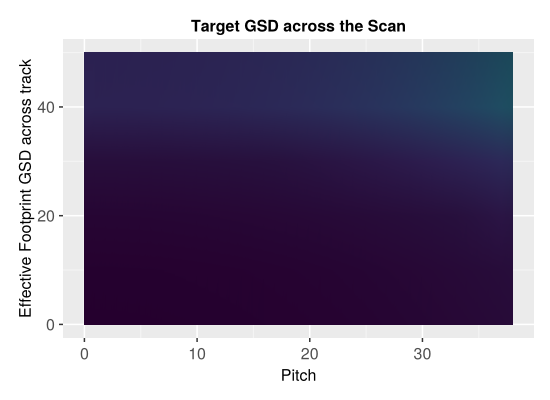

In [40]:
f = Figure(resolution=(550,400))
lowerLim = 4.0

ax = Axis(f[1,1], xlabel="Pitch", ylabel="Effective Footprint GSD across track",  title="Target GSD across the Scan")
surface!(ax, pitch_deg, roll_deg, footprint_sizes; colormap=:viridis,  colorbar=true)
#lines!(ax, pitch_deg , computeAcrossTrackSize(0.0), color=CarbonI_colors[5], linewidth=2, label="Roll Angle = 45°")

#axislegend(ax,position = :lt;  labelsize=12)
#ylims!(ax, 0, 140)
f


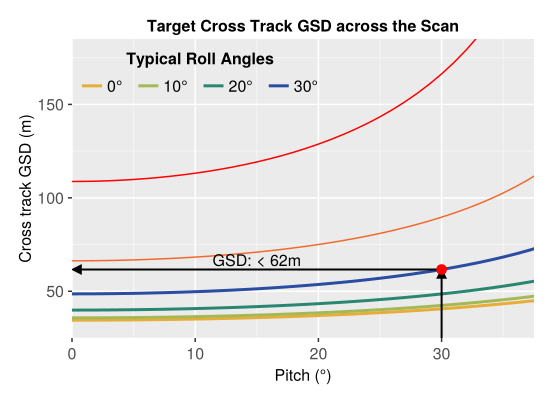

In [ ]:
f = Figure(resolution=(550,400))
lowerLim = 4.0

ax = Axis(f[1,1], xlabel="Pitch (°)", ylabel="Cross track GSD (m)",  title="Target Cross Track GSD across the Scan")
sc1 = lines!(ax, pitch_deg , footprint_sizes[:,1], color=CarbonI_colors[1], linewidth=3,  label="Roll = 0°")
sc2 = lines!(ax, pitch_deg , footprint_sizes[:,2], color=CarbonI_colors[2], linewidth=3,  label="10°")
sc3 = lines!(ax, pitch_deg , footprint_sizes[:,3], color=CarbonI_colors[3], linewidth=3,  label="20°")
sc4 = lines!(ax, pitch_deg , footprint_sizes[:,4], color=CarbonI_colors[4], linewidth=3,  label="30°")
sc5 = lines!(ax, pitch_deg , footprint_sizes[:,5], color=CarbonI_colors[5], linewidth=1.5,  label="40°")
sc6 = lines!(ax, pitch_deg , footprint_sizes[:,6], color=:red, linewidth=1.5,  label="50°")

index = 31
req_gsd = footprint_sizes[index,4]



text!(ax, "GSD: < $(round(Int, req_gsd))m", position = (pitch_deg[index]/2, req_gsd),
    align = (:center, :bottom), color = :black)
arrows!(ax, [pitch_deg[index],],[req_gsd,],[-pitch_deg[index]+0.5,],[0,],arrowsize = 15, linewidth=2, color = :black, alpha=0.5)
arrows!(ax, [pitch_deg[index],],[0],[0,],[req_gsd-3,],arrowsize = 15, linewidth=2, color = :black, alpha=0.5)
scatter!(ax, [pitch_deg[index]], [req_gsd], color=:red, markersize=15, label="Driving")
#lines!(ax, [eff_cbe,eff_cbe], [2,6], color=:black, linestyle=:dash, linewidth=2, label="CBE Total Efficiency")

#lines!(ax, pitch_deg , computeAcrossTrackSize(0.0), color=CarbonI_colors[5], linewidth=2, label="Roll Angle = 45°")
axislegend(ax, [sc1, sc2,sc3,sc4], ["0°", "10°","20°","30°"], "Typical Roll Angles", position = :lt,
    orientation = :horizontal)
axislegend(ax, [sc5, sc6], ["40°", "50°"], "Capable Roll Angles", position = :rt,
    orientation = :horizontal)

ylims!(ax, 25, 185)
xlims!(ax, 0, 37.5)
f

In [26]:
using Statistics
mean_xTrack_GSD = median([computeAcrossTrackSize(0.0)[1]; computeAcrossTrackSize(15)[1] ; computeAcrossTrackSize(30.0)[1]]);
@show mean_xTrack_GSD/34.5

UndefVarError: UndefVarError: `computeAcrossTrackSize` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [28]:
using LinearAlgebra

###############################################################################
# Constants
###############################################################################
const R_EARTH = 6378.137  # approximate Earth radius in km

###############################################################################
# Basic geometry helpers
###############################################################################

"Return rotation matrix about local X-axis by angle θ."
function rotX(θ)
    c, s = cos(θ), sin(θ)
    return Matrix([
        1.0  0.0  0.0
        0.0   c   -s
        0.0   s    c
    ])
end

"Return rotation matrix about local Y-axis by angle θ."
function rotY(θ)
    c, s = cos(θ), sin(θ)
    return Matrix([
         c   0.0    s
        0.0  1.0   0.0
        -s   0.0    c
    ])
end

"Convert (lat, lon) in radians + radius to ECEF [x, y, z]."
function latlon_to_ecef(lat::Float64, lon::Float64, r::Float64)
    x = r * cos(lat) * cos(lon)
    y = r * cos(lat) * sin(lon)
    z = r * sin(lat)
    return [x, y, z]
end

"""
    ecef_to_latlon(pos::Vector{Float64}) -> (lat, lon)

Convert ECEF [x, y, z] to spherical (lat, lon) in radians.
"""
function ecef_to_latlon(pos::Vector{Float64})
    x, y, z = pos
    r_xy = sqrt(x^2 + y^2)
    lat  = atan(z, r_xy)
    lon  = atan(y, x)
    return (lat, lon)
end

"""
    build_enu(lat0, lon0) -> (e, n, u)

Build local East, North, Up vectors (each length=1) at lat0, lon0 (radians).
These are expressed in ECEF coordinates.
"""
function build_enu(lat0::Float64, lon0::Float64)
    # Up (zenith)
    u = [cos(lat0)*cos(lon0),
         cos(lat0)*sin(lon0),
         sin(lat0)]
    # East
    e = [-sin(lon0),
          cos(lon0),
          0.0]
    # North
    n = cross(u, e)  # or cross(e, u), depending on sign
    return (e, n, u)
end

"""
    footprint_extents_spherical(lat0, lon0, h, pitch, roll, alpha; R=R_EARTH, N=180)

Compute the bounding-box footprint dimensions in the local East and North
directions for a circular sensor half-angle `alpha`, from altitude `h` above
a spherical Earth of radius `R`. The satellite is at (lat0, lon0).

Angles (pitch, roll, alpha) in radians.  `N` is how many azimuth steps around
the cone to sample. Returns (width_across, width_along) in the same units as R,h.

- `pitch` is rotation about local x (East), so +pitch tilts sensor forward/back along track (northbound).
- `roll`  is rotation about local y (North), so +roll tilts sensor left/right across track.
- The result accounts for Earth curvature.  A forward pitch can stretch the
  across-track width, etc.
"""
function footprint_extents_spherical(lat0, lon0, h, pitch, roll, alpha; R=R_EARTH, N=180)

    # 1) Satellite position in ECEF:
    sat_ecef = latlon_to_ecef(lat0, lon0, R + h)

    # 2) Sub-satellite point on Earth surface (radius=R)
    subsat_ecef = latlon_to_ecef(lat0, lon0, R)

    # 3) Local axes (e, n, u) in ECEF
    ê, n̂, û = build_enu(lat0, lon0)

    # 4) Boresight in local (ENU) coords: start with (0,0,-1) = "nadir"
    v_local_nadir = [0.0, 0.0, -1.0]

    #    Apply roll about X, then pitch about Y:
    #    (If your pitch/roll definitions differ, reorder these calls.)
    rot_local = rotY(pitch) * rotX(roll)
    v_local_boresight = rot_local * v_local_nadir  # in local ENU coords

    # 5) Convert that boresight into ECEF by linear combo of (e, n, u)
    v_b = v_local_boresight[1]*ê +
          v_local_boresight[2]*n̂ +
          v_local_boresight[3]*û
    v_b = normalize(v_b)  # just to be safe

    # 6) Build orthonormal vectors e1, e2 perpendicular to v_b (for the cone)
    #    We'll pick e1 = (v_b × û) × v_b as a "horizontal" vector,
    #    then e2 = v_b × e1.  There's some arbitrariness but that's ok.
    tmp = cross(v_b, û)
    if norm(tmp) < 1e-9
        # degenerate if v_b is near +/- up.  fallback to cross with ê
        tmp = cross(v_b, ê)
    end
    e1 = cross(tmp, v_b)
    e1 = e1 / norm(e1)
    e2 = cross(v_b, e1)
    e2 = e2 / norm(e2)

    # We'll sample directions around the cone using phi in [0, 2π).
    phivals = range(0, 2π, length=N+1)[1:end-1]

    e_vals = Float64[]
    n_vals = Float64[]

    # Ray-sphere intersection function:
    # X(t) = sat_ecef + t*v_dir,  want ||X(t)||=R => solve quadratic
    function intersect_earth(sat::Vector{Float64}, dir::Vector{Float64}, R::Float64)
        # Solve ||sat + t*dir||^2 = R^2
        S, V = sat, dir
        SdotS = dot(S,S)
        SdotV = dot(S,V)
        VdotV = dot(V,V)
        a = VdotV
        b = 2*SdotV
        c = SdotS - R^2
        disc = b^2 - 4a*c
        if disc < 0
            return nothing  # no real intersection
        end
        sqrt_disc = sqrt(disc)
        t1 = (-b + sqrt_disc)/(2a)
        t2 = (-b - sqrt_disc)/(2a)
        # We want the solution that is physically "below" the satellite.
        # Usually, if dir is downward, t might be negative. So let's pick the
        # one that yields a smaller |sat + t*dir - sat|.  i.e. the one
        # that is closest to sat along the correct direction.
        t_candidates = [t1, t2]
        # filter out NaNs
        t_candidates = filter(!isnan, t_candidates)
        if isempty(t_candidates)
            return nothing
        end
        # pick whichever has minimal distance to the satellite
        distfun(t) = norm(S + t*V - S)
        t_best = t_candidates[argmin(distfun.(t_candidates))]
        return S + t_best*V
    end

    # 7) Loop over cone boundary:
    for φ in phivals
        # direction in ECEF for the cone's surface
        v_cone = v_b*cos(alpha) + e1*sin(alpha)*cos(φ) + e2*sin(alpha)*sin(φ)
        v_cone = normalize(v_cone)

        # Intersection:
        X_int = intersect_earth(sat_ecef, v_cone, R)
        if X_int === nothing
            continue
        end

        # Convert to local offsets from sub-satellite point:
        dx = X_int .- subsat_ecef
        e_ = dot(dx, ê)
        n_ = dot(dx, n̂)

        push!(e_vals, e_)
        push!(n_vals, n_)
    end

    # 8) Compute bounding box in e/n
    dE = (isempty(e_vals)) ? 0.0 : (maximum(e_vals) - minimum(e_vals))
    dN = (isempty(n_vals)) ? 0.0 : (maximum(n_vals) - minimum(n_vals))

    return (dE*1000, dN*1000)
end


#################################
# Example usage / test
#################################
#if abspath(PROGRAM_FILE) == @__FILE__
    # Example: satellite at lat=0°, lon=0°, altitude=700 km
    # pitch=10° forward, roll=5° right, FOV half-angle=2°
    lat0_deg  = 0.0
    lon0_deg  = 0.0
    h_km      = 668.0
    pitch_deg = 30.0
    roll_deg  = 30.0
    alpha_deg = rad2deg(51.7/1000000/2)
    @show alpha_deg

    # convert degrees -> radians
    #deg2rad(x) = x * pi/180
    lat0 = deg2rad(lat0_deg)
    lon0 = deg2rad(lon0_deg)
    pitch = deg2rad(pitch_deg)
    roll  = deg2rad(roll_deg)
    alpha = deg2rad(alpha_deg)

    D_across, D_along = footprint_extents_spherical(lat0, lon0, h_km, pitch, roll, alpha;
                                                    R=R_EARTH, N=180)

    println("Across-track width: $D_across m")
    println("Along-track  width: $D_along  m")
#end




alpha_deg = 0.001481095900413178
Across-track width: 58.56116892078944 m
Along-track  width: 61.652308485292906  m
